In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [109]:
#df = pd.read_csv("")
dfs = pd.read_excel("Data.xlsx", sheet_name=None)
dfs.keys()
plants = dfs['plants']
flight_dates =dfs['flight dates']
weather = dfs['weather']
planting = dfs['planting']

In [110]:
#rename the weather data which column is Unnamed: 0
weather= weather.rename(columns={'Unnamed: 0':'Plant Date'})

In [111]:
# Add flight dates from 2020 plant data.
df = plants.merge(flight_dates, how='left', on='Batch Number')
df = df.drop(['Flight Date_x'], axis=1)
#check missing data
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4859 entries, 0 to 4858
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Batch Number          4859 non-null   int64         
 1   Plant Date            4685 non-null   datetime64[ns]
 2   Class                 4859 non-null   int64         
 3   Fresh Weight (g)      4858 non-null   float64       
 4   Head Weight (g)       4754 non-null   float64       
 5   Radial Diameter (mm)  4754 non-null   float64       
 6   Polar Diameter (mm)   4754 non-null   float64       
 7   Diameter Ratio        4752 non-null   float64       
 8   Leaves                100 non-null    float64       
 9   Density (kg/L)        4672 non-null   float64       
 10  Leaf Area (cm^2)      4857 non-null   float64       
 11  Square ID             4859 non-null   int64         
 12  Check Date            4859 non-null   datetime64[ns]
 13  Remove            

,Batch Number,Plant Date,Class,Fresh Weight (g),Head Weight (g),Radial Diameter (mm),Polar Diameter (mm),Diameter Ratio,Leaves,Density (kg/L),Leaf Area (cm^2),Square ID,Check Date,Remove,Flight Date_y
0,402,2020-04-11,3,15.0,NaN,NaN,NaN,NaN,10.0,NaN,185.0,208,2020-04-30,NaN,2020-04-30
1,402,2020-04-11,4,15.0,NaN,NaN,NaN,NaN,11.0,NaN,156.0,208,2020-04-30,NaN,2020-04-30
2,402,2020-04-11,1,16.0,NaN,NaN,NaN,NaN,12.0,NaN,137.0,208,2020-04-30,NaN,2020-04-30
3,402,2020-04-11,3,15.0,NaN,NaN,NaN,NaN,10.0,NaN,225.0,208,2020-04-30,NaN,2020-04-30
4,402,2020-04-11,3,15.0,NaN,NaN,NaN,NaN,11.0,NaN,157.0,208,2020-04-30,NaN,2020-04-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4854,738,2020-08-27,4,284.0,12.0,50.0,55.0,0.909091,NaN,NaN,430.0,1172,2020-10-20,NaN,NaT
4855,738,2020-08-27,5,199.0,8.0,45.0,85.0,0.529412,NaN,NaN,358.0,1172,2020-10-20,NaN,NaT
4856,738,2020-08-27,3,280.0,23.0,60.0,80.0,0.750000,NaN,NaN,417.0,1172,2020-10-20,NaN,NaT
4857,738,2020-08-27,4,247.0,10.0,45.0,80.0,0.562500,NaN,NaN,413.0,1172,2020-10-20,NaN,NaT


In [112]:
#check how many 'r' is in the Remove
df['Remove'].value_counts()
#find the r
indexNames = df[ df['Remove'] == 'r' ].index
#drop the row which Remove = r
df.drop(indexNames , inplace=True)

In [113]:
# we dont need remove anymore
#drop remove
df = df.drop(['Remove'], axis=1)

In [114]:
#drop plant date which is null
df = df.dropna(axis='index', how='all', subset=['Plant Date'])

In [115]:
# create days to check
df['days_to_check'] = pd.to_datetime(df['Flight Date_y'])-pd.to_datetime(df['Plant Date'])
df = df.drop(['Flight Date_y'], axis=1)

In [116]:
#days to check column trandfer to int
a = df[:4615]['days_to_check'] / np.timedelta64(1, 'D')
type(a)

pandas.core.series.Series

In [117]:
#transfer seris to dataframe
a=a.to_frame()
#rename days to check to check days
df = df.rename(columns={'days_to_check':'check_days'})
#merge two data
df = pd.concat([df,a],axis = 1)
#drop the check days which did not transfer to int
df = df.drop(['check_days'], axis = 1)

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4615 entries, 0 to 4858
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Batch Number          4615 non-null   int64         
 1   Plant Date            4615 non-null   datetime64[ns]
 2   Class                 4615 non-null   int64         
 3   Fresh Weight (g)      4614 non-null   float64       
 4   Head Weight (g)       4510 non-null   float64       
 5   Radial Diameter (mm)  4510 non-null   float64       
 6   Polar Diameter (mm)   4510 non-null   float64       
 7   Diameter Ratio        4508 non-null   float64       
 8   Leaves                100 non-null    float64       
 9   Density (kg/L)        4428 non-null   float64       
 10  Leaf Area (cm^2)      4613 non-null   float64       
 11  Square ID             4615 non-null   int64         
 12  Check Date            4615 non-null   datetime64[ns]
 13  days_to_check     

In [119]:
df.isnull().sum()

Batch Number               0
Plant Date                 0
Class                      0
Fresh Weight (g)           1
Head Weight (g)          105
Radial Diameter (mm)     105
Polar Diameter (mm)      105
Diameter Ratio           107
Leaves                  4515
Density (kg/L)           187
Leaf Area (cm^2)           2
Square ID                  0
Check Date                 0
days_to_check           1321
dtype: int64

In [120]:
#column leave fill null data in zero
df['Leaves'] = df['Leaves'].fillna(0)

In [121]:
#fill in zero when leaves is not zero
df.loc[df.Leaves != 0 ,'Head Weight (g)'] = 0

In [122]:
df.loc[df.Leaves != 0 ,'Radial Diameter (mm)'] = 0

In [123]:
df.loc[df.Leaves != 0 ,'Polar Diameter (mm)'] = 0

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4615 entries, 0 to 4858
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Batch Number          4615 non-null   int64         
 1   Plant Date            4615 non-null   datetime64[ns]
 2   Class                 4615 non-null   int64         
 3   Fresh Weight (g)      4614 non-null   float64       
 4   Head Weight (g)       4610 non-null   float64       
 5   Radial Diameter (mm)  4610 non-null   float64       
 6   Polar Diameter (mm)   4610 non-null   float64       
 7   Diameter Ratio        4508 non-null   float64       
 8   Leaves                4615 non-null   float64       
 9   Density (kg/L)        4428 non-null   float64       
 10  Leaf Area (cm^2)      4613 non-null   float64       
 11  Square ID             4615 non-null   int64         
 12  Check Date            4615 non-null   datetime64[ns]
 13  days_to_check     

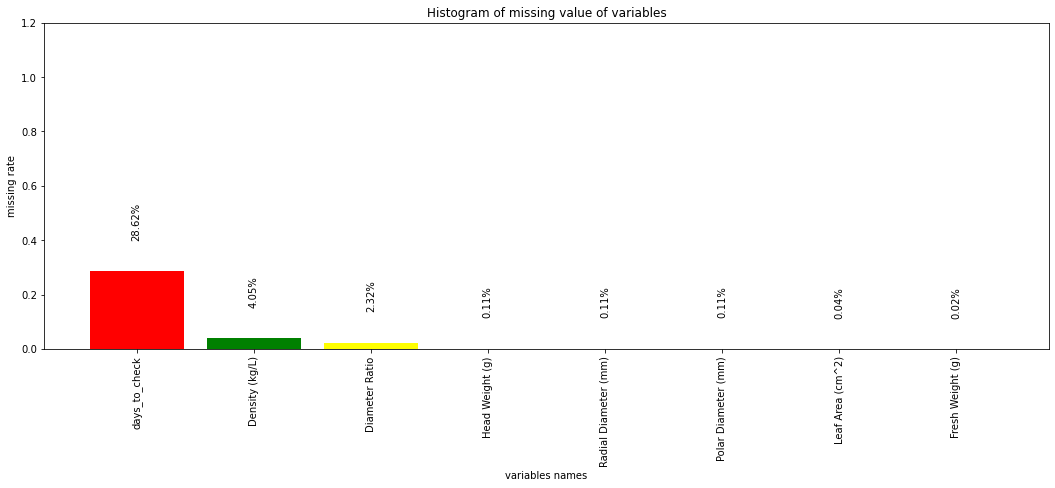

In [125]:
# cuculate the missing data
missing=df.isnull().sum().reset_index().rename(columns={0:'missNum'})
# cuculate the missing rate
missing['missRate']=missing['missNum']/df.shape[0]
# rank the missing rate
miss_analy=missing[missing.missRate>0].sort_values(by='missRate',ascending=False)
# miss_analy 

import matplotlib.pyplot as plt
import pylab as pl

fig = plt.figure(figsize=(18,6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align = 'center'
    ,color=['red','green','yellow','steelblue'])

plt.title('Histogram of missing value of variables')
plt.xlabel('variables names')
plt.ylabel('missing rate')
plt.xticks(np.arange(miss_analy.shape[0]),list(miss_analy['index']))
pl.xticks(rotation=90)
for x,y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x,y+0.12,'{:.2%}'.format(y),ha='center',rotation=90)    
plt.ylim([0,1.2])
    
plt.show()

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4615 entries, 0 to 4858
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Batch Number          4615 non-null   int64         
 1   Plant Date            4615 non-null   datetime64[ns]
 2   Class                 4615 non-null   int64         
 3   Fresh Weight (g)      4614 non-null   float64       
 4   Head Weight (g)       4610 non-null   float64       
 5   Radial Diameter (mm)  4610 non-null   float64       
 6   Polar Diameter (mm)   4610 non-null   float64       
 7   Diameter Ratio        4508 non-null   float64       
 8   Leaves                4615 non-null   float64       
 9   Density (kg/L)        4428 non-null   float64       
 10  Leaf Area (cm^2)      4613 non-null   float64       
 11  Square ID             4615 non-null   int64         
 12  Check Date            4615 non-null   datetime64[ns]
 13  days_to_check     

In [127]:
#drop leak data
df= df.drop(['Diameter Ratio'], axis = 1)
df= df.drop(['Density (kg/L)'], axis = 1)

In [128]:
#rename some of colunms
df = df.rename(columns={'Head Weight (g)':'head_weight', 'Radial Diameter (mm)':'radial_diameter','Polar Diameter (mm)':'polar_diameter','Fresh Weight (g)':'fresh_weight','Leaf Area (cm^2)':'leaf_area','days_to _check':'day_to_check'})

In [129]:
df.head(50)

,Batch Number,Plant Date,Class,fresh_weight,head_weight,radial_diameter,polar_diameter,Leaves,leaf_area,Square ID,Check Date,days_to_check
0,402,2020-04-11,3,15.0,0.0,0.0,0.0,10.0,185.0,208,2020-04-30,19.0
1,402,2020-04-11,4,15.0,0.0,0.0,0.0,11.0,156.0,208,2020-04-30,19.0
2,402,2020-04-11,1,16.0,0.0,0.0,0.0,12.0,137.0,208,2020-04-30,19.0
3,402,2020-04-11,3,15.0,0.0,0.0,0.0,10.0,225.0,208,2020-04-30,19.0
4,402,2020-04-11,3,15.0,0.0,0.0,0.0,11.0,157.0,208,2020-04-30,19.0
5,402,2020-04-11,2,14.0,0.0,0.0,0.0,10.0,206.0,208,2020-04-30,19.0
6,402,2020-04-11,2,21.0,0.0,0.0,0.0,11.0,236.0,208,2020-04-30,19.0
7,402,2020-04-11,3,14.0,0.0,0.0,0.0,11.0,159.0,208,2020-04-30,19.0
8,402,2020-04-11,2,13.0,0.0,0.0,0.0,11.0,205.0,208,2020-04-30,19.0
9,402,2020-04-11,1,16.0,0.0,0.0,0.0,11.0,165.0,208,2020-04-30,19.0


In [130]:
weather

,Plant Date,Solar Radiation [avg],Precipitation [sum],Wind Speed [avg],Wind Speed [max],Battery Voltage [last],Leaf Wetness [time],Air Temperature [avg],Air Temperature [max],Air Temperature [min],Relative Humidity [avg],Dew Point [avg],Dew Point [min],ET0 [result]
0,2014-05-14,159,0.0,1.4,3.3,6834,70,14.27,18.90,7.19,64.95,7.0,5.6,NaN
1,2014-05-15,280,0.0,0.6,2.3,6894,500,13.51,22.06,3.04,72.91,7.6,3.0,3.6
2,2014-05-16,186,3.4,0.8,2.7,6874,375,15.65,24.24,7.23,74.69,10.5,6.5,2.9
3,2014-05-17,221,0.0,1.0,3.3,6874,565,17.46,25.70,9.93,71.42,11.5,8.1,3.6
4,2014-05-18,255,0.0,2.1,5.5,6854,625,16.85,24.62,8.45,74.45,11.4,8.3,4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,2021-05-17,196,1.4,2.2,5.5,7166,0,10.51,14.53,8.95,99.86,10.3,8.8,NaN
2552,2021-05-17,173,2.8,1.8,5.5,6864,0,10.80,14.53,8.38,99.86,10.6,8.2,NaN
2553,2021-05-18,311,0.0,1.4,5.0,6854,0,10.29,17.14,3.15,92.94,8.8,3.0,3.4
2554,2021-05-19,232,6.6,1.8,5.5,6864,0,11.39,16.61,7.50,90.32,9.4,5.2,3.0


In [131]:
#merge weather data
data_all = df.merge(weather, how='left', on='Plant Date')

In [132]:
data_all.head(50)

,Batch Number,Plant Date,Class,fresh_weight,head_weight,radial_diameter,polar_diameter,Leaves,leaf_area,Square ID,...,Wind Speed [max],Battery Voltage [last],Leaf Wetness [time],Air Temperature [avg],Air Temperature [max],Air Temperature [min],Relative Humidity [avg],Dew Point [avg],Dew Point [min],ET0 [result]
0,402,2020-04-11,3,15.0,0.0,0.0,0.0,10.0,185.0,208,...,4.5,6884,0,14.75,24.45,4.42,64.24,6.5,4.3,3.7
1,402,2020-04-11,4,15.0,0.0,0.0,0.0,11.0,156.0,208,...,4.5,6884,0,14.75,24.45,4.42,64.24,6.5,4.3,3.7
2,402,2020-04-11,1,16.0,0.0,0.0,0.0,12.0,137.0,208,...,4.5,6884,0,14.75,24.45,4.42,64.24,6.5,4.3,3.7
3,402,2020-04-11,3,15.0,0.0,0.0,0.0,10.0,225.0,208,...,4.5,6884,0,14.75,24.45,4.42,64.24,6.5,4.3,3.7
4,402,2020-04-11,3,15.0,0.0,0.0,0.0,11.0,157.0,208,...,4.5,6884,0,14.75,24.45,4.42,64.24,6.5,4.3,3.7
5,402,2020-04-11,2,14.0,0.0,0.0,0.0,10.0,206.0,208,...,4.5,6884,0,14.75,24.45,4.42,64.24,6.5,4.3,3.7
6,402,2020-04-11,2,21.0,0.0,0.0,0.0,11.0,236.0,208,...,4.5,6884,0,14.75,24.45,4.42,64.24,6.5,4.3,3.7
7,402,2020-04-11,3,14.0,0.0,0.0,0.0,11.0,159.0,208,...,4.5,6884,0,14.75,24.45,4.42,64.24,6.5,4.3,3.7
8,402,2020-04-11,2,13.0,0.0,0.0,0.0,11.0,205.0,208,...,4.5,6884,0,14.75,24.45,4.42,64.24,6.5,4.3,3.7
9,402,2020-04-11,1,16.0,0.0,0.0,0.0,11.0,165.0,208,...,4.5,6884,0,14.75,24.45,4.42,64.24,6.5,4.3,3.7


In [133]:
data_all[data_all["head_weight"].isnull()]
data_all = data_all.dropna(axis='index', how='all', subset=['head_weight'])

In [134]:
# transfer datetime to float
# change them into the time passed since a specific reference time point
time0 = pd.Timestamp('2020-01-01')
data_all['Plant Date'] = (data_all['Plant Date'] - time0).values.astype(float)
data_all['Check Date'] = (data_all['Check Date'] - time0).values.astype(float)
#df['Flight Date_y'] = (df['Flight Date_y'] - time0).values.astype(float)

In [135]:
data_all = data_all.dropna()

In [136]:
data_all = data_all.reset_index()
data_all = data_all.drop(['index'], axis=1)

In [137]:
data_all

,Batch Number,Plant Date,Class,fresh_weight,head_weight,radial_diameter,polar_diameter,Leaves,leaf_area,Square ID,...,Wind Speed [max],Battery Voltage [last],Leaf Wetness [time],Air Temperature [avg],Air Temperature [max],Air Temperature [min],Relative Humidity [avg],Dew Point [avg],Dew Point [min],ET0 [result]
0,402,8.726400e+15,3,15.0,0.0,0.0,0.0,10.0,185.0,208,...,4.5,6884,0,14.75,24.45,4.42,64.24,6.5,4.3,3.7
1,402,8.726400e+15,4,15.0,0.0,0.0,0.0,11.0,156.0,208,...,4.5,6884,0,14.75,24.45,4.42,64.24,6.5,4.3,3.7
2,402,8.726400e+15,1,16.0,0.0,0.0,0.0,12.0,137.0,208,...,4.5,6884,0,14.75,24.45,4.42,64.24,6.5,4.3,3.7
3,402,8.726400e+15,3,15.0,0.0,0.0,0.0,10.0,225.0,208,...,4.5,6884,0,14.75,24.45,4.42,64.24,6.5,4.3,3.7
4,402,8.726400e+15,3,15.0,0.0,0.0,0.0,11.0,157.0,208,...,4.5,6884,0,14.75,24.45,4.42,64.24,6.5,4.3,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3286,690,1.883520e+16,1,513.0,144.0,100.0,95.0,0.0,450.0,92,...,4.2,6854,0,21.43,26.90,16.93,83.72,18.2,15.5,3.6
3287,690,1.883520e+16,1,514.0,158.0,110.0,100.0,0.0,500.0,92,...,4.2,6854,0,21.43,26.90,16.93,83.72,18.2,15.5,3.6
3288,690,1.883520e+16,2,500.0,106.0,98.0,93.0,0.0,530.0,92,...,4.2,6854,0,21.43,26.90,16.93,83.72,18.2,15.5,3.6
3289,690,1.883520e+16,4,480.0,137.0,108.0,82.0,0.0,490.0,92,...,4.2,6854,0,21.43,26.90,16.93,83.72,18.2,15.5,3.6


In [138]:
data_all.describe()

,Batch Number,Plant Date,Class,fresh_weight,head_weight,radial_diameter,polar_diameter,Leaves,leaf_area,Square ID,...,Wind Speed [max],Battery Voltage [last],Leaf Wetness [time],Air Temperature [avg],Air Temperature [max],Air Temperature [min],Relative Humidity [avg],Dew Point [avg],Dew Point [min],ET0 [result]
count,3291.000000,3.291000e+03,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,...,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000
mean,580.346703,1.527245e+16,2.965664,542.683875,227.387116,106.996050,99.362200,0.312063,471.308417,394.347919,...,5.091492,6876.719538,37.288058,15.742598,21.426873,10.061778,77.198879,11.035886,7.891249,3.695229
std,81.217774,2.629745e+15,1.432060,309.422604,201.980497,44.470997,37.271069,1.924606,198.036412,433.711591,...,1.811849,11.710284,119.388030,3.506394,3.955275,3.959798,8.372631,3.947864,4.266008,1.018422
min,402.000000,8.726400e+15,1.000000,0.632000,0.000000,0.000000,0.000000,0.000000,74.000000,4.000000,...,3.000000,6844.000000,0.000000,8.820000,14.180000,0.290000,52.010000,1.700000,-1.400000,1.900000
25%,514.000000,1.347840e+16,2.000000,286.000000,39.500000,75.000000,80.000000,0.000000,328.000000,84.000000,...,3.800000,6874.000000,0.000000,14.010000,18.960000,7.810000,71.500000,8.900000,5.800000,2.900000
50%,607.000000,1.598400e+16,3.000000,529.000000,183.000000,120.000000,107.000000,0.000000,452.000000,238.000000,...,4.600000,6884.000000,0.000000,14.790000,20.390000,9.870000,75.380000,9.600000,7.000000,3.500000
75%,649.000000,1.736640e+16,4.000000,776.000000,375.000000,140.000000,130.000000,0.000000,580.500000,529.000000,...,5.700000,6884.000000,0.000000,18.120000,24.450000,12.700000,83.720000,13.500000,10.000000,4.300000
max,693.000000,1.900800e+16,5.000000,1978.000000,998.000000,185.000000,178.000000,22.000000,1276.000000,2019.000000,...,10.300000,6894.000000,545.000000,22.290000,29.570000,16.990000,95.440000,18.200000,15.700000,6.400000


In [139]:
#find the cor
#select the important feature that relate to target(polar_diameter,radial_diameter,head_weight)
import seaborn as sns
import matplotlib.pyplot as plt

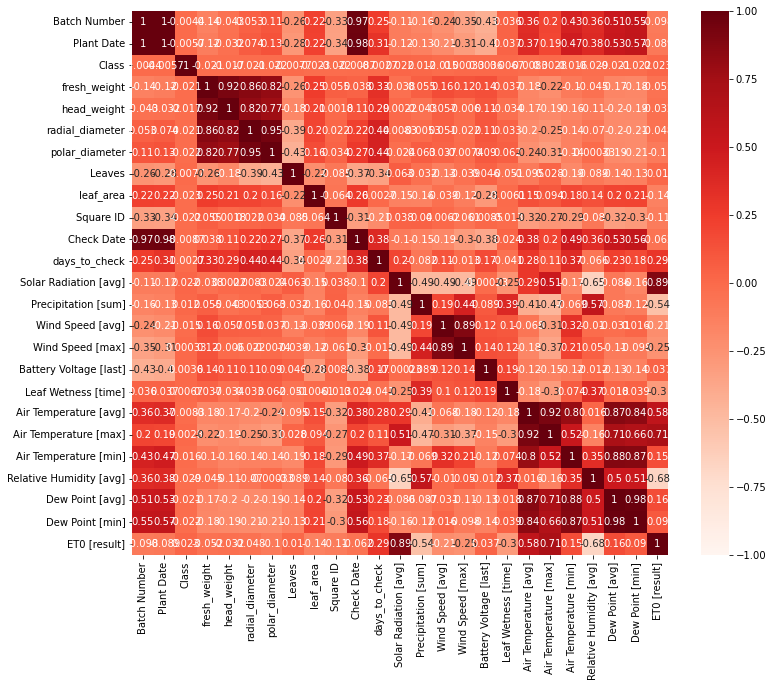

In [140]:
correlations = data_all.corr()
correlations['polar_diameter'].sort_values(ascending=False)
plt.figure(figsize=(12,10))
sns.heatmap(correlations, annot=True, cmap=plt.cm.Reds, vmax=1, vmin=-1)
plt.show()

In [195]:
#correlation with target radial diameter
targetCorr = abs(correlations['radial_diameter'])
targetCorr = targetCorr.drop('radial_diameter')
selectedFeatures = targetCorr[targetCorr>0.15]
print(f"Number of selected features: {len(selectedFeatures)} \n\nHighly relative feature list:\n{selectedFeatures}")

Number of selected features: 11 

Highly relative feature list:
fresh_weight             0.863635
head_weight              0.821789
polar_diameter           0.945294
Leaves                   0.390233
leaf_area                0.197104
Check Date               0.222318
days_to_check            0.436538
Air Temperature [avg]    0.197914
Air Temperature [max]    0.253426
Dew Point [avg]          0.196717
Dew Point [min]          0.205736
Name: radial_diameter, dtype: float64


In [194]:
#correlation with target polar diameter
targetCorr = abs(correlations['polar_diameter'])
targetCorr = targetCorr.drop('polar_diameter')
selectedFeatures = targetCorr[targetCorr>0.15]
print(f"Number of selected features: {len(selectedFeatures)} \n\nHighly relative feature list:\n{selectedFeatures}")

Number of selected features: 11 

Highly relative feature list:
fresh_weight             0.818589
head_weight              0.772481
radial_diameter          0.945294
Leaves                   0.432396
leaf_area                0.163476
Check Date               0.269775
days_to_check            0.437031
Air Temperature [avg]    0.237038
Air Temperature [max]    0.308538
Dew Point [avg]          0.194673
Dew Point [min]          0.206880
Name: polar_diameter, dtype: float64


In [193]:
#correlation with target head weight
targetCorr = abs(correlations['head_weight'])
targetCorr = targetCorr.drop('head_weight')
selectedFeatures = targetCorr[targetCorr>0.15]
print(f"Number of selected features: {len(selectedFeatures)} \n\nHighly relative feature list:\n{selectedFeatures}")

Number of selected features: 11 

Highly relative feature list:
fresh_weight             0.916827
radial_diameter          0.821789
polar_diameter           0.772481
Leaves                   0.182595
leaf_area                0.208590
days_to_check            0.291274
Air Temperature [avg]    0.171324
Air Temperature [max]    0.187647
Air Temperature [min]    0.162590
Dew Point [avg]          0.196151
Dew Point [min]          0.194033
Name: head_weight, dtype: float64


In [144]:
#low_cor = data_all[['Wind Speed [avg]','Wind Speed [max]','Leaf Wetness [time]','Square ID','Precipitation [sum]','Relative Humidity [avg]']]

In [145]:
#drop the low correlation features
data_lowcor = data_all.drop(['Wind Speed [avg]','Wind Speed [max]','Leaf Wetness [time]','Square ID','Precipitation [sum]','Relative Humidity [avg]'], axis=1)

In [146]:
data_lowcor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3291 entries, 0 to 3290
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Batch Number            3291 non-null   int64  
 1   Plant Date              3291 non-null   float64
 2   Class                   3291 non-null   int64  
 3   fresh_weight            3291 non-null   float64
 4   head_weight             3291 non-null   float64
 5   radial_diameter         3291 non-null   float64
 6   polar_diameter          3291 non-null   float64
 7   Leaves                  3291 non-null   float64
 8   leaf_area               3291 non-null   float64
 9   Check Date              3291 non-null   float64
 10  days_to_check           3291 non-null   float64
 11  Solar Radiation [avg]   3291 non-null   int64  
 12  Battery Voltage [last]  3291 non-null   int64  
 13  Air Temperature [avg]   3291 non-null   float64
 14  Air Temperature [max]   3291 non-null   

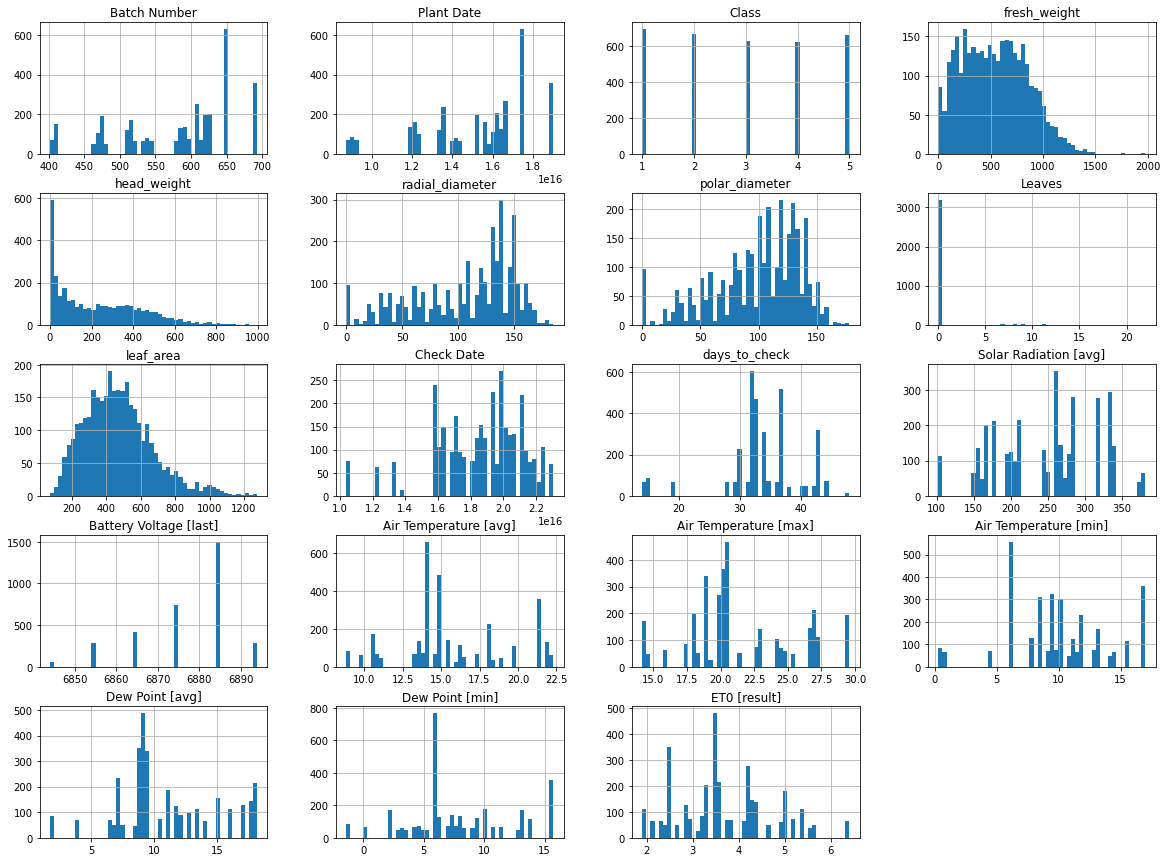

In [147]:
#check data
_ = data_lowcor.hist(bins=50, figsize=(20,15))

In [148]:
data_lowcor.describe()

,Batch Number,Plant Date,Class,fresh_weight,head_weight,radial_diameter,polar_diameter,Leaves,leaf_area,Check Date,days_to_check,Solar Radiation [avg],Battery Voltage [last],Air Temperature [avg],Air Temperature [max],Air Temperature [min],Dew Point [avg],Dew Point [min],ET0 [result]
count,3291.000000,3.291000e+03,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3.291000e+03,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000
mean,580.346703,1.527245e+16,2.965664,542.683875,227.387116,106.996050,99.362200,0.312063,471.308417,1.862730e+16,33.773929,247.017016,6876.719538,15.742598,21.426873,10.061778,11.035886,7.891249,3.695229
std,81.217774,2.629745e+15,1.432060,309.422604,201.980497,44.470997,37.271069,1.924606,198.036412,2.645920e+15,6.373430,67.771476,11.710284,3.506394,3.955275,3.959798,3.947864,4.266008,1.018422
min,402.000000,8.726400e+15,1.000000,0.632000,0.000000,0.000000,0.000000,0.000000,74.000000,1.036800e+16,14.000000,102.000000,6844.000000,8.820000,14.180000,0.290000,1.700000,-1.400000,1.900000
25%,514.000000,1.347840e+16,2.000000,286.000000,39.500000,75.000000,80.000000,0.000000,328.000000,1.702080e+16,32.000000,193.000000,6874.000000,14.010000,18.960000,7.810000,8.900000,5.800000,2.900000
50%,607.000000,1.598400e+16,3.000000,529.000000,183.000000,120.000000,107.000000,0.000000,452.000000,1.926720e+16,33.000000,260.000000,6884.000000,14.790000,20.390000,9.870000,9.600000,7.000000,3.500000
75%,649.000000,1.736640e+16,4.000000,776.000000,375.000000,140.000000,130.000000,0.000000,580.500000,2.039040e+16,37.000000,286.000000,6884.000000,18.120000,24.450000,12.700000,13.500000,10.000000,4.300000
max,693.000000,1.900800e+16,5.000000,1978.000000,998.000000,185.000000,178.000000,22.000000,1276.000000,2.306880e+16,48.000000,382.000000,6894.000000,22.290000,29.570000,16.990000,18.200000,15.700000,6.400000


In [149]:
#train set for all features
x = data_all.drop(['head_weight','radial_diameter','polar_diameter'], axis=1)

In [150]:
#target for all features
y = data_all[['head_weight','radial_diameter','polar_diameter']]

In [151]:
# train set for features have been selected
X = data_lowcor.drop(['head_weight','radial_diameter','polar_diameter'], axis=1)

In [152]:
# target for features have been selected
Y = data_lowcor[['head_weight','radial_diameter','polar_diameter']]

In [153]:
#prepare data for classification medel
y_class = data_all[['head_weight','radial_diameter','polar_diameter']]

In [154]:
# Give the number
y_class['head_size'] =0

/Users/liu/anaconda3/envs/ce802/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [155]:
y_class['radial_size']=0
y_class['polar_size']=0

/Users/liu/anaconda3/envs/ce802/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/liu/anaconda3/envs/ce802/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [156]:
#give category according the Quartile Deviation
y_class.loc[y_class['head_weight']<40,'head_size'] = 0

y_class.loc[(y_class['head_weight']>=40)&(y_class['head_weight']<183),'head_size'] = 1

y_class.loc[(y_class['head_weight']>=183)&(y_class['head_weight']<375),'head_size'] = 2

y_class.loc[y_class['head_weight']>=375,'head_size'] = 3


/Users/liu/anaconda3/envs/ce802/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [157]:
#give category according the Quartile Deviation
y_class.loc[y_class['radial_diameter']<75,'radial_size'] = 0

y_class.loc[(y_class['radial_diameter']>=75)&(y_class['radial_diameter']<120),'radial_size'] = 1

y_class.loc[(y_class['radial_diameter']>=120)&(y_class['radial_diameter']<140),'radial_size'] = 2

y_class.loc[y_class['radial_diameter']>=140,'radial_size'] = 3

In [158]:
#give category according the Quartile Deviation
y_class.loc[y_class['polar_diameter']<80,'polar_size'] = 0

y_class.loc[(y_class['polar_diameter']>=80)&(y_class['polar_diameter']<107),'polar_size'] = 1

y_class.loc[(y_class['polar_diameter']>=107)&(y_class['polar_diameter']<130),'polar_size'] = 2

y_class.loc[y_class['polar_diameter']>=130,'polar_size'] = 3

In [159]:
#target for all features
y_class = y_class.drop(['head_weight','radial_diameter','polar_diameter'], axis=1)

In [160]:
y_class

,head_size,radial_size,polar_size
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
3286,1,1,1
3287,1,1,1
3288,1,1,1
3289,1,1,1


In [161]:
y_classh = y_class.drop(['radial_size','polar_size'], axis=1)
y_classr = y_class.drop(['head_size','polar_size'], axis=1)
y_classp = y_class.drop(['head_size','radial_size'], axis=1)

In [162]:
from sklearn.model_selection import train_test_split, cross_val_score

In [225]:
# Create separate training and test sets in all feature
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=50)  

In [226]:
# Create separate training and test sets in  selectrd feature
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=50)

In [227]:
# Create separate training and test sets for classcification model(selected feature)
Xc_train,Xc_test, Yc_train, Yc_test = train_test_split(X, y_class, test_size=0.3, random_state=50)

In [228]:
# Create separate training and test sets for classcification model(all feature)
xc_train,xc_test, yc_train, yc_test = train_test_split(x, y_class, test_size=0.3, random_state=50)

In [229]:
Xh_train,Xh_test, Yh_train, Yh_test = train_test_split(X, y_classh, test_size=0.3, random_state=50)
Xr_train, Xr_test, Yr_train, Yr_test = train_test_split(X, y_classr, test_size=0.3, random_state=50)
Xp_train, Xp_test, Yp_train, Yp_test = train_test_split(X, y_classp, test_size=0.3, random_state=50)

In [230]:
#check
print(" x_train:",len(x_train),'\n',"x_test:",len(x_test),'\n',"y_train:",len(y_train),'\n',"y_test:",len(y_test))

 x_train: 2303 
 x_test: 988 
 y_train: 2303 
 y_test: 988


In [231]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

In [232]:
#predict
ml = MultiOutputRegressor(GradientBoostingRegressor(random_state=50)).fit(x_train, y_train)

In [233]:
ML = MultiOutputRegressor(GradientBoostingRegressor(random_state=50)).fit(X_train, Y_train)

In [234]:
R = MultiOutputRegressor(RandomForestRegressor(random_state=50)).fit(X_train, Y_train)

In [235]:
r = MultiOutputRegressor(RandomForestRegressor(random_state=50)).fit(x_train, y_train)

In [236]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=50)
from sklearn.multioutput import MultiOutputClassifier

In [237]:
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1).fit(Xc_train, Yc_train)

In [238]:
multi_target_foresta = MultiOutputClassifier(forest, n_jobs=-1).fit(xc_train, yc_train)

In [239]:
predict = ml.predict(x_test)

In [240]:
PREDICT = ML.predict(X_test)

In [241]:
PREDICTR = R.predict(X_test)

In [242]:
predictr = r.predict(x_test)

In [243]:
PREDICTX = multi_target_forest.predict(Xc_test)

In [244]:
predictx = multi_target_foresta.predict(xc_test)

In [245]:

mean_squared_error(y_test, predict,multioutput='raw_values') 

array([2507.1852601 ,  130.46224243,  133.88666584])

In [246]:
r2_score(y_test, predict, multioutput='raw_values')

array([0.93697349, 0.93466138, 0.90433807])

In [247]:
mean_squared_error(Y_test, PREDICT,multioutput='raw_values') 

array([2558.43535576,  130.7153184 ,  133.53023286])

In [248]:
r2_score(Y_test, PREDICT, multioutput='raw_values')

array([0.93568515, 0.93453464, 0.90459274])

In [249]:
mean_squared_error(Y_test, PREDICTR,multioutput='raw_values') 

array([2623.94800213,  133.30582196,  126.37693623])

In [250]:
r2_score(Y_test, PREDICTR, multioutput='raw_values')

array([0.93403827, 0.93323725, 0.90970376])

In [251]:
mean_squared_error(y_test, predictr,multioutput='raw_values') 

array([2555.91806346,  132.28920334,  124.48934909])

In [252]:
r2_score(y_test, predictr, multioutput='raw_values')

array([0.93574843, 0.9337464 , 0.91105244])

In [180]:
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.metrics import roc_auc_score

In [253]:
Yc_test = Yc_test.to_numpy()

In [254]:
yc_test = yc_test.to_numpy()

In [255]:
def example_subset_accuracy(gt, predict):
    ex_equal = np.all(np.equal(gt, predict), axis=1).astype("float32")
    return np.mean(ex_equal)

In [256]:
example_subset_accuracy(Yc_test, PREDICTX)

0.5617409

In [257]:
example_subset_accuracy(yc_test, predictx)

0.555668

In [231]:
print('MSE =', mean_squared_error(y_test, predict))
print('R^2:',ml.score(x_test, y_test))

MSE = 974.0011681732159
R^2: 0.9248885439189802


In [232]:
print('MSE =', mean_squared_error(Y_test, PREDICT))
print('R^2:',ML.score(X_test, Y_test))

MSE = 968.6319671005094
R^2: 0.9249540224623255


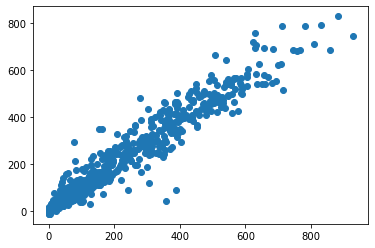

In [76]:
plt.scatter(y_test,predict)

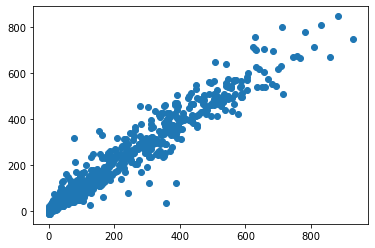

In [90]:
plt.scatter(Y_test,PREDICT)

In [78]:
from sklearn import datasets, linear_model

In [79]:
lr = MultiOutputRegressor(linear_model.Lasso(random_state=50)).fit(x_train, y_train)

/Users/liu/anaconda3/envs/ce802/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.710e+06, tolerance: 1.074e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/liu/anaconda3/envs/ce802/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.869e+05, tolerance: 5.165e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/liu/anaconda3/envs/ce802/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, ch

In [91]:
LR = MultiOutputRegressor(linear_model.Lasso(random_state=50)).fit(X_train, Y_train)

/Users/liu/anaconda3/envs/ce802/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.857e+06, tolerance: 1.074e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/liu/anaconda3/envs/ce802/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.880e+05, tolerance: 5.165e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/liu/anaconda3/envs/ce802/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, ch

In [92]:
predict1 = lr.predict(x_test)
PREDICT1 = LR.predict(X_test)

In [81]:
print('MSE =', mean_squared_error(y_test, predict1))
print('R^2:',lr.score(x_test, y_test))

MSE = 1854.624607240997
R^2: 0.8496376743212811


In [93]:
print('MSE =', mean_squared_error(Y_test, PREDICT1))
print('R^2:',LR.score(X_test, Y_test))

MSE = 1896.0724436634819
R^2: 0.8485189114895199


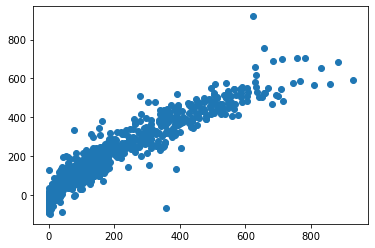

In [82]:
plt.scatter(y_test,predict1)

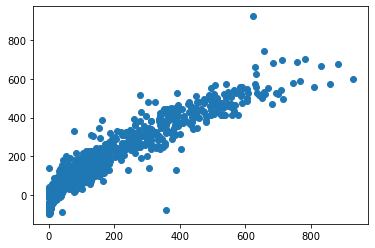

In [94]:
plt.scatter(Y_test,PREDICT1)